In [ ]:
# https://github.com/Ksuryateja/DCGAN-MNIST-pytorch 참조

In [19]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [20]:
cudnn.benchmark = True

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
# 난수 생성을 위한 시드 설정
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8914


In [23]:
# MNIST 데이터셋 로드
dataset = dset.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

100%|██████████| 9912422/9912422 [00:00<00:00, 85452662.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38763422.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31719034.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20418573.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:
# 이미지 채널(흑백이므로 1)
nc=1
# GPU
ngpu = 1
# noise 차원
nz = 100
# Generator Filter 수
ngf = 64
# Discriminator Filters 수
ndf = 64

In [25]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

In [28]:
# 가중치 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [29]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [34]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [31]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [35]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [32]:
# 목적함수
criterion = nn.BCELoss()

In [36]:
# 최적화
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 노이즈 벡터
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 실제 데이터과 가짜 데이터 라벨링
real_label = 1
fake_label = 0

# 반복 횟수
niter = 25

In [51]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        # Discriminator 업데이트 : maximize log(D(x)) + log(1 - D(G(z)))
        # 실제 데이터 훈련
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 데이터 훈련
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        # Generator 업데이트 : maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label.float())
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                   % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
num_gpu = 1 if torch.cuda.is_available() else 0

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[19/25][628/938] Loss_D: 0.8807 Loss_G: 1.8009 D(x): 0.6482 D(G(z)): 0.2612 / 0.1939
[19/25][629/938] Loss_D: 0.7412 Loss_G: 1.3351 D(x): 0.6536 D(G(z)): 0.2169 / 0.2953
[19/25][630/938] Loss_D: 0.8340 Loss_G: 2.0050 D(x): 0.8094 D(G(z)): 0.4185 / 0.1609
[19/25][631/938] Loss_D: 0.9708 Loss_G: 1.7085 D(x): 0.6078 D(G(z)): 0.3226 / 0.2117
[19/25][632/938] Loss_D: 0.9116 Loss_G: 1.2860 D(x): 0.5720 D(G(z)): 0.2124 / 0.3277
[19/25][633/938] Loss_D: 1.0323 Loss_G: 1.9444 D(x): 0.8252 D(G(z)): 0.5056 / 0.1774
[19/25][634/938] Loss_D: 0.9347 Loss_G: 1.8743 D(x): 0.6432 D(G(z)): 0.3296 / 0.1782
[19/25][635/938] Loss_D: 1.1483 Loss_G: 1.0451 D(x): 0.4618 D(G(z)): 0.2033 / 0.4045
[19/25][636/938] Loss_D: 1.0923 Loss_G: 1.6293 D(x): 0.7569 D(G(z)): 0.5057 / 0.2285
[19/25][637/938] Loss_D: 0.8344 Loss_G: 1.9227 D(x): 0.6868 D(G(z)): 0.3111 / 0.1773
[19/25][638/938] Loss_D: 0.8540 Loss_G: 1.6296 D(x): 0.6447 D(G(z)): 0.2850 / 0.2428
[19/25][639/938] Loss_D: 0.77

In [55]:
# 모델 저장
torch.save(netG.state_dict(), 'netG.pth')
torch.save(netD.state_dict(), 'netD.pth')

In [56]:
# 모델 불러오기

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

D.load_state_dict(torch.load('netD.pth'))
G.load_state_dict(torch.load('netG.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

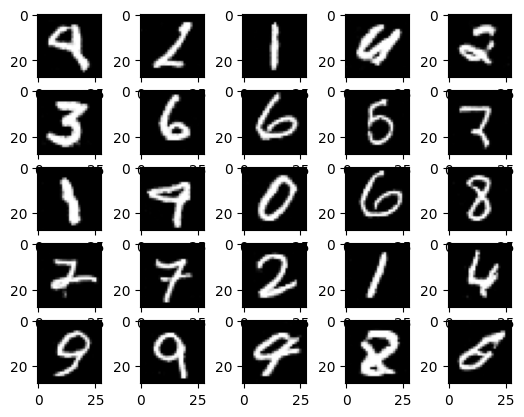

In [59]:
# 생성된 이미지 확인
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()